In [31]:
Packages <- c("nleqslv","viridis", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")

set.seed(7)

#define my own cv function
cv <- function(x){
    sd(x)/mean(x)
}

#function for 0.99 recruitment
cdf_solve99 <- function (d, theta = theta_eval, k = k_eval) 
{
    return(cdf(d, theta, k) - 0.495)$x
}
#make a mean dispersal distance function that can be applied to a DT rather than for loop method I've used in the past

mean_disp_dist <- function(k, theta){
    
x <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k, theta=theta, , method = "pcubature")$integral)

return(x)

}

In [53]:
SimKernels
GenKernels

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-0.38751254,0.6370261,3.778224,2.096410,9.305059,-725758.2,simulation_08PLD
annual,2013,-0.64237719,0.6792543,4.080705,2.351905,9.967812,-662951.4,simulation_08PLD
annual,2014,0.07565334,0.5641438,3.504783,1.797263,8.749074,-629397.4,simulation_08PLD
interannual,2012-4,-0.31231809,0.6214930,3.770613,2.060501,9.314044,-2021633.6,simulation_08PLD
season,Amihan,-0.43151979,0.6569262,3.617719,2.044842,8.875493,-1864791.3,simulation_08PLD
season,Habagat,0.23883526,0.4673893,6.354512,2.826102,16.085780,-128013.1,simulation_08PLD


time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-3.27091,3.52876,13.02,12.02,25.08,-17.26499,genetics
annual,2013,-3.27484,5.00000,12.77,12.18,23.91,-112.75593,genetics
annual,2014,1.97231,0.26016,76.00,17.47,182.37,-78.48620,genetics
interannual,2012-4,-0.22643,0.43900,13.69,5.77,34.74,-218.61429,genetics
season,Amihan,0.76361,0.37294,12.87,4.64,32.61,-27.26112,genetics
season,Habagat,-3.38408,5.00000,14.25,13.59,26.67,-71.81265,genetics


In [96]:
#read in the simulation kernel fits
SimKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFits08DayPLD.csv")[, data_source := "simulation_08PLD"][
    time_id=="NEM", time_id := "Amihan"][
    time_id=="SWM", time_id := "Habagat"]
#SimKernels15PLD <- fread("~/oceanography/script_output/KernelFits/SimulationKernelFits15DayPLD.csv")[, data_source := "simulation_15PLD"][
#    time_id=="NEM", time_id := "Amihan"][
#    time_id=="SWM", time_id := "Habagat"]

#setnames(SimKernels, c("TimeID", "TimeScale"), c("time_id", "time_scale")) #from now on, DTs will be named LikeThis, vectors (including colnames and row ids) will be like_this- until I get around to making that consistent in every script, rename here
#read in the Genetics kernel fits with the same reef metadata structure
GenKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/GeneticKernelFits.csv")[
    time_id=="NEM", time_id := "Amihan"][
    time_id=="SWM", time_id := "Habagat"]

#read in the likelihood surfaces tables
#Genetics
ProfileGen2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2012NarrowSearch.csv", header = T)
ProfileGen2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2013NarrowSearch.csv", header = T)
ProfileGen2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2014NarrowSearch.csv", header = T)
ProfileGen2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2012_4NarrowSearch.csv", header = T)
ProfileGenNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGeneticNEMNarrowSearch.csv", header = T)
ProfileGenSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGeneticSWMNarrowSearch.csv", header = T)

#ROMS simulations
ProfileSim2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012NarrowSearch08DayPLD.csv", header = T)
ProfileSim2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2013NarrowSearch08DayPLD.csv", header = T)
ProfileSim2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2014NarrowSearch08DayPLD.csv", header = T)
ProfileSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012_4NarrowSearch08DayPLD.csv", header = T)
ProfileSimNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalNEMNarrowSearch08DayPLD.csv", header = T)
ProfileSimSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalSWMNarrowSearch08DayPLD.csv", header = T)

#ensure the likelihood surfaces found the same best fit as the bbmle optimization for both simulation and Geneticss
#done
#calculate the 95% likelihood surface cutoffs. Use the log_like from the bbmle function because that's more precise. in the grid search function used for the surfaces, k/theta are limited to 2 decimal places because it's less computation time, but in some cases that means the MLE is from an artificial local optimum that only exists because decimal places are truncated
#genetics
cutoff_Gen2012 <- min(ProfileGen2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012 <- ProfileGen2012[, `:=`(data_source="genetics", time_id="2012", cutoff=cutoff_Gen2012, best_k=GenKernels[time_id=="2012", k], best_theta=GenKernels[time_id=="2012", theta])]
ProfileGen2012_CI95 <- ProfileGen2012[log_like < cutoff_Gen2012]

cutoff_Gen2013 <- min(ProfileGen2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2013 <- ProfileGen2013[, `:=`(data_source="genetics", time_id="2013", cutoff=cutoff_Gen2013, best_k=GenKernels[time_id=="2013", k], best_theta=GenKernels[time_id=="2013", theta])]
ProfileGen2013_CI95 <- ProfileGen2013[log_like < cutoff_Gen2013]

cutoff_Gen2014 <- min(ProfileGen2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2014 <- ProfileGen2014[, `:=`(data_source="genetics", time_id="2014", cutoff=cutoff_Gen2014, best_k=GenKernels[time_id=="2014", k], best_theta=GenKernels[time_id=="2014", theta])]
ProfileGen2014_CI95 <- ProfileGen2014[log_like < cutoff_Gen2014]

cutoff_Gen2012_4 <- min(ProfileGen2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_4 <- ProfileGen2012_4[, `:=`(data_source="genetics", time_id="2012-4", cutoff=cutoff_Gen2012_4,  best_k=GenKernels[time_id=="2012-4", k], best_theta=GenKernels[time_id=="2012-4", theta])]
ProfileGen2012_4_CI95 <- ProfileGen2012_4[log_like < cutoff_Gen2012_4]

cutoff_GenNEM <- min(ProfileGenNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenNEM <- ProfileGenNEM[, `:=`(data_source="genetics", time_id="Amihan", cutoff=cutoff_GenNEM, best_k=GenKernels[time_id=="Amihan", k], best_theta=GenKernels[time_id=="Amihan", theta])]
ProfileGenNEM_CI95 <- ProfileGenNEM[log_like < cutoff_GenNEM]

cutoff_GenSWM <- min(ProfileGenSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenSWM <- ProfileGenSWM[, `:=`(data_source="genetics", time_id="Habagat", cutoff=cutoff_GenSWM, best_k=GenKernels[time_id=="Habagat", k], best_theta=GenKernels[time_id=="Habagat", theta])]
ProfileGenSWM_CI95 <- ProfileGenSWM[log_like < cutoff_GenSWM]

#biophysical simulation
cutoff_Sim2012 <- min(ProfileSim2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012 <- ProfileSim2012[, `:=`(data_source="simulation_08PLD", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]
ProfileSim2012_CI95 <- ProfileSim2012[log_like < cutoff_Sim2012]

cutoff_Sim2013 <- min(ProfileSim2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2013 <- ProfileSim2013[, `:=`(data_source="simulation_08PLD", time_id="2013", cutoff=cutoff_Sim2013, best_k=SimKernels[time_id=="2013", k], best_theta=SimKernels[time_id=="2013", theta])]
ProfileSim2013_CI95 <- ProfileSim2013[log_like < cutoff_Sim2013]

cutoff_Sim2014 <- min(ProfileSim2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2014 <- ProfileSim2014[, `:=`(data_source="simulation_08PLD", time_id="2014", cutoff=cutoff_Sim2014,  best_k=SimKernels[time_id=="2014", k], best_theta=SimKernels[time_id=="2014", theta])]
ProfileSim2014_CI95 <- ProfileSim2014[log_like < cutoff_Sim2014]

cutoff_Sim2012_4 <- min(ProfileSim2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_4 <- ProfileSim2012_4[, `:=`(data_source="simulation_08PLD", time_id="2012-4", cutoff=cutoff_Sim2012_4,  best_k=SimKernels[time_id=="2012-4", k], best_theta=SimKernels[time_id=="2012-4", theta])]
ProfileSim2012_4_CI95 <- ProfileSim2012_4[log_like < cutoff_Sim2012_4]

cutoff_SimNEM <- min(ProfileSimNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimNEM <- ProfileSimNEM[, `:=`(data_source="simulation_08PLD", time_id="Amihan", cutoff=cutoff_SimNEM,  best_k=SimKernels[time_id=="Amihan", k], best_theta=SimKernels[time_id=="Amihan", theta])]

ProfileSimNEM_CI95 <- ProfileSimNEM[log_like < cutoff_SimNEM]
cutoff_SimSWM <- min(ProfileSimSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimSWM <- ProfileSimSWM[, `:=`(data_source="simulation_08PLD", time_id="Habagat", cutoff=cutoff_SimSWM,  best_k=SimKernels[time_id=="Habagat", k], best_theta=SimKernels[time_id=="Habagat", theta])]
ProfileSimSWM_CI95 <- ProfileSimSWM[log_like < cutoff_SimSWM]



In [97]:
##combine into one table for plotting, maybe move to later after getting upper and lower profiles
GenPlusSimKernels95CI <- rbindlist(list(ProfileGen2012_CI95, ProfileGen2013_CI95, ProfileGen2013_CI95, ProfileGen2014_CI95, ProfileGen2012_4_CI95, ProfileGenNEM_CI95, ProfileGenSWM_CI95,
             ProfileSim2012_CI95, ProfileSim2013_CI95, ProfileSim2014_CI95, ProfileSim2012_4_CI95, ProfileSimNEM_CI95, ProfileSimSWM_CI95))#[ 
    #, `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
    #                        med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
    #                        dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
    #                  by=c("k_eval", "theta_eval")]
#fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CI.csv")

#11/23/2021- remaking plots to draw from whole likelihood surface
GenPlusSimKernels <- rbindlist(list(ProfileGen2012, ProfileGen2013, ProfileGen2013, ProfileGen2014, ProfileGen2012_4, ProfileGenNEM, ProfileGenSWM,
             ProfileSim2012, ProfileSim2013, ProfileSim2014, ProfileSim2012_4, ProfileSimNEM, ProfileSimSWM))#[ 
    #, `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
    #                        med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
    #                        dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
    #                  by=c("k_eval", "theta_eval")]

In [98]:
##add in the 15 day PLD kernels
##ROMS simulations
#Profile_15PLDSim2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSim2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2013NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSim2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2014NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012_4NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSimNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalNEMNarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSimSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalSWMNarrowSearch15DayPLD.csv", header = T)
#
##biophysical simulation
#cutoff_15PLDSim2012 <- min(Profile_15PLDSim2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2012_CI95 <- Profile_15PLDSim2012[log_like < cutoff_15PLDSim2012][, `:=`(data_source="simulation_15PLD", time_id="2012", cutoff=cutoff_15PLDSim2012, best_k=SimKernels15PLD[time_id=="2012", k], best_theta=SimKernels15PLD[time_id=="2012", theta])]
#
#cutoff_15PLDSim2013 <- min(Profile_15PLDSim2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2013_CI95 <- Profile_15PLDSim2013[log_like < cutoff_15PLDSim2013][, `:=`(data_source="simulation_15PLD", time_id="2013", cutoff=cutoff_15PLDSim2013, best_k=SimKernels15PLD[time_id=="2013", k], best_theta=SimKernels15PLD[time_id=="2013", theta])]
#
#cutoff_15PLDSim2014 <- min(Profile_15PLDSim2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2014_CI95 <- Profile_15PLDSim2014[log_like < cutoff_15PLDSim2014][, `:=`(data_source="simulation_15PLD", time_id="2014", cutoff=cutoff_15PLDSim2014,  best_k=SimKernels15PLD[time_id=="2014", k], best_theta=SimKernels15PLD[time_id=="2014", theta])]
#
#cutoff_15PLDSim2012_4 <- min(Profile_15PLDSim2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2012_4_CI95 <- Profile_15PLDSim2012_4[log_like < cutoff_15PLDSim2012_4][, `:=`(data_source="simulation_15PLD", time_id="2012-4", cutoff=cutoff_15PLDSim2012_4,  best_k=SimKernels15PLD[time_id=="2012-4", k], best_theta=SimKernels15PLD[time_id=="2012-4", theta])]
#
#cutoff_15PLDSimNEM <- min(Profile_15PLDSimNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSimNEM_CI95 <- Profile_15PLDSimNEM[log_like < cutoff_15PLDSimNEM][, `:=`(data_source="simulation_15PLD", time_id="NEM", cutoff=cutoff_15PLDSimNEM,  best_k=SimKernels15PLD[time_id=="NEM", k], best_theta=SimKernels15PLD[time_id=="NEM", theta])]
#
#cutoff_15PLDSimSWM <- min(Profile_15PLDSimSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSimSWM_CI95 <- Profile_15PLDSimSWM[log_like < cutoff_15PLDSimSWM][, `:=`(data_source="simulation_15PLD", time_id="SWM", cutoff=cutoff_15PLDSimSWM,  best_k=SimKernels15PLD[time_id=="SWM", k], best_theta=SimKernels15PLD[time_id=="SWM", theta])]
#
#GenPlusSimKernels95CI <- rbindlist(list(GenPlusSimKernels95CI,
#             Profile_15PLDSim2012_CI95, Profile_15PLDSim2013_CI95, Profile_15PLDSim2014_CI95, Profile_15PLDSim2012_4_CI95, Profile_15PLDSimNEM_CI95, Profile_15PLDSimSWM_CI95))
#
#fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CIBothPLDOptions.csv")
GenPlusSimKernels95CI[, .N, by=.(time_id, data_source)]
#GenPlusSimKernels[, .N, by=.(time_id, data_source)]

time_id,data_source,N
2012,genetics,231068
2013,genetics,979990
2014,genetics,139241
2012-4,genetics,17230
Amihan,genetics,68908
Habagat,genetics,505126
2012,simulation_08PLD,381093
2013,simulation_08PLD,329459
2014,simulation_08PLD,1000000
2012-4,simulation_08PLD,1000000


In [100]:
GenPlusSimKernels95CI[time_id=="2014" & data_source =="simulation_08PLD"]

k_eval,theta_eval,log_like,data_source,time_id,cutoff,best_k,best_theta
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438
0.06503252,0.5657329,629398.4,simulation_08PLD,2014,629401.4,0.07565334,0.5641438


In [27]:
20.26073>20.26023

[1] TRUE

In [99]:
GenPlusSimKernels95CILower <- GenPlusSimKernels95CI[k_eval <= best_k & theta_eval <= best_theta, .(lower_k=k_eval, lower_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "lower"][
    log_like ==max_log_like, .(lower_k, lower_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CIUpper <- GenPlusSimKernels95CI[k_eval >= best_k & theta_eval >= best_theta][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "upper"][
    log_like ==max_log_like, .(upper_k, upper_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CISummary <- unique(GenPlusSimKernels95CILower[GenPlusSimKernels95CIUpper, on=.(time_id, data_source)], by= c("time_id", "data_source"))

GenSummary <- GenPlusSimKernels95CISummary[GenKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]  
SimSummary <- GenPlusSimKernels95CISummary[SimKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]    
#SimSummary15PLD <- GenPlusSimKernels95CISummary[SimKernels15PLD, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]    

SimSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI
#SimSummary15PLD[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI
GenSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI

KernelFittingSummary <- rbindlist(list(SimSummary, GenSummary))[, -"log_like"]# SimSummary15PLD,
KernelFittingSummary[, `:=`(upper_mdd=round(mean_disp_dist(k = lower_k, theta=lower_theta), 2),
                            lower_mdd=round(mean_disp_dist(k = upper_k, theta=upper_theta), 2),
                            upper_med=round(nleqslv(x = 7, fn = cdf_solve, k=lower_k, theta=lower_theta)$x, 2),
                            lower_med=round(nleqslv(x = 7, fn = cdf_solve, k=upper_k, theta=upper_theta)$x, 2)),
                      by=c("time_id", "data_source")]
setcolorder(KernelFittingSummary, c("data_source", "time_scale", "time_id", "lower_k", "k", "upper_k", "lower_theta", "theta", "upper_theta", "lower_mdd", "mdd", "upper_mdd", "lower_med", "med", "upper_med")) 
KernelFittingSummary
#fwrite(KernelFittingSummary, "~/oceanography/script_output/KernelFits/summary_tables/KernelFittingSummary.csv")

time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


ERROR: Error in nleqslv(x = 7, fn = cdf_solve, k = lower_k, theta = lower_theta): initial value of fn function contains non-finite values (starting at index=1)
  Check initial x and/or correctness of function


In [13]:
SimSummary

time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like
2012,simulation_08PLD,NA,NA,NA,NA,annual,-0.388,0.637,3.778224,2.096410,9.305059,-725758.2
2013,simulation_08PLD,NA,NA,NA,NA,annual,-0.642,0.679,4.080705,2.351905,9.967812,-662951.4
2014,simulation_08PLD,NA,NA,NA,NA,annual,0.076,0.564,3.504783,1.797263,8.749074,-629397.4
2012-4,simulation_08PLD,NA,NA,NA,NA,interannual,-0.312,0.621,3.770613,2.060501,9.314044,-2021633.6
Amihan,simulation_08PLD,NA,NA,NA,NA,season,-0.432,0.657,3.617719,2.044842,8.875493,-1864791.3
Habagat,simulation_08PLD,0.232,0.467,0.24,0.468,season,0.239,0.467,6.354512,2.826102,16.085780,-128013.1


In [ ]:
725761.128134017

In [23]:
head(GenPlusSimKernels95CI[time_id=="2012" & data_source=="simulation_08PLD"])

k_eval,theta_eval,log_like,data_source,time_id,cutoff,best_k,best_theta
-0.3751876,0.6343672,725760.5,simulation_08PLD,2012,725761.8,-0.3875125,0.6370261
-0.3851926,0.6368184,725758.8,simulation_08PLD,2012,725761.8,-0.3875125,0.6370261


In [18]:
#reformat summary table for publication
KernelFittingSummaryPub <- KernelFittingSummary[data_source != "simulation_15PLD"][, .(k=paste(lower_k, k, upper_k),
                                                                                         theta=paste(lower_theta, theta, upper_theta),
                                                                                         mdd=paste(lower_mdd, mdd, upper_mdd)), by=c("data_source", "time_id")]
#fwrite(KernelFittingSummaryPub, "~/oceanography/script_output/KernelFits/summary_tables/KernelFittingSummaryPublication.csv")

ERROR: Error in paste(lower_mdd, mdd, upper_mdd): object 'lower_mdd' not found


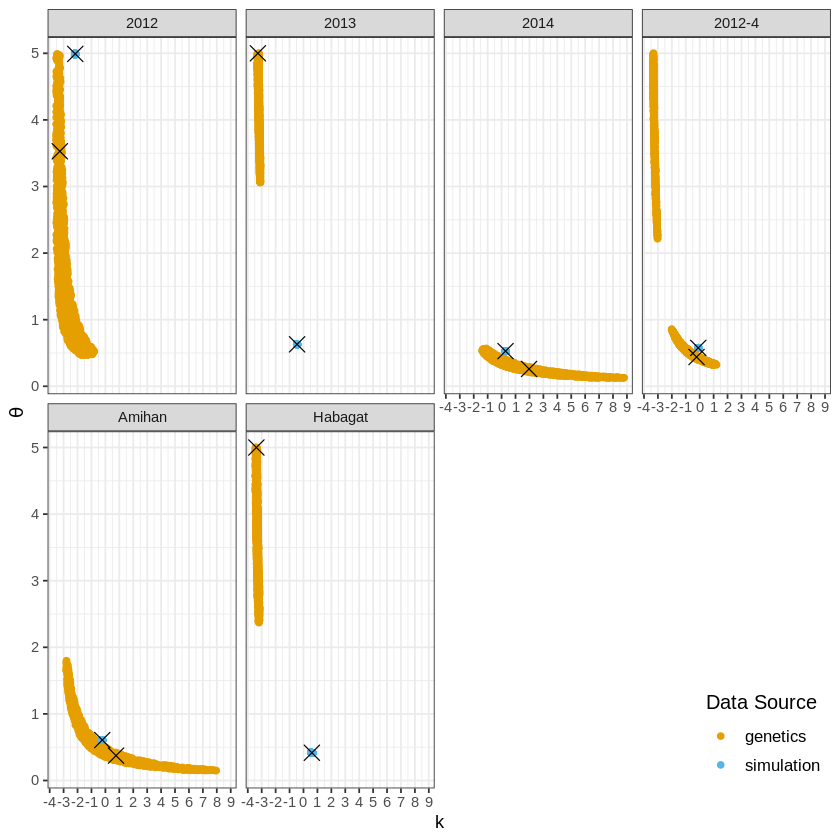

In [64]:
GenPlusSimKernels95CI$time_id <- factor(GenPlusSimKernels95CI$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
#PubKernels$time_id <- factor(PubKernels$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
GenPlusSimKernels95CI$data_source <- factor(GenPlusSimKernels95CI$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

surface <- ggplot() +
        geom_point(data=GenPlusSimKernels95CI[data_source != "simulation_15PLD"][, .SD[sample(.N, 1000, prob=max(log_like)/log_like)], by = c("time_id", "data_source")], aes(x=k_eval, y=theta_eval, color=data_source, fill=data_source)) +
        geom_point(data=KernelFittingSummary[data_source != "simulation_15PLD"], aes(x=k, y=theta),shape=4, size=4) + #, color=data_source, fill=data_source
        #geom_point(data=PubKernels, aes(x=best_k, y=best_theta),shape=8, size=4) + #, color=data_source, fill=data_source
        scale_x_continuous(breaks = seq(-10, 10, by = 1)) + #, expand = c(0, 0)
        scale_y_continuous(breaks = seq(0, 6, by = 1)) +#, expand = c(0, 0)
        theme(axis.text.x = element_text(size=15, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
        axis.text.y =  element_text(size=15, color="black"),
        axis.title.y =  element_text(size=15, color="black"), 
        axis.title.x =  element_text(size=15, color="black")) +
        xlab("k") + ylab(expression(theta)) +
        theme_bw() + 
        scale_colour_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
        scale_fill_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
        facet_wrap(~ time_id, ncol = 4)+
        theme(legend.position = c(1, 0),
        legend.justification = c(1,0),legend.title = element_text(colour="black", size = 12), legend.text = element_text(colour="black", size = 10))
#surface_grid <- surface +facet_grid(cols=vars(time_id), fig.width=6)
surface
#ggsave(filename="SurfaceGrid.pdf",  plot=surface, path="~/oceanography/script_output/plots/", units="in", width=8, height=6)


In [32]:

GenPlusSimKernelsSamp <- GenPlusSimKernels[, .SD[sample(.N, 100, prob=min(log_like)/log_like)], by = c("time_id", "data_source")][ #weight the fits by distance from the best log like
    , `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
                            med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2)),
                      by=c("k_eval", "theta_eval")]



In [ ]:
#plot the actual dispersal kernels

In [33]:
#make a dt with the pdf values at each distance to plot for each kernel fit, use 200 kernel fits not 1000

ToPlot <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(GenPlusSimKernelsSamp95CI))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
              do.call("rbind", replicate(length(seq(0, 80, 0.1)), GenPlusSimKernelsSamp95CI[, .(time_id, data_source, k_eval, theta_eval, group=.I)], simplify = FALSE))) #add the group number for plotting

nrow(ToPlot)==nrow(GenPlusSimKernelsSamp95CI)*length(seq(0, 80, 0.1)) #should be true

#add a column for pdf value at that distance

ToPlot[, pdf := predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval),
                      by=c("k_eval", "theta_eval", "dist_eval")]
BestFits <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(KernelFittingSummary))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
            do.call("rbind", replicate(length(seq(0, 80, 0.1)), KernelFittingSummary[, .(time_id, data_source, k, theta, group=.I)], simplify = FALSE)))[ #add the group number for plotting
            , pdf := predicted_disp(k=k, theta=theta, d=dist_eval),
                      by=c("k", "theta", "dist_eval")]


[1] TRUE

In [128]:
 head(ToPlot)

dist_eval,time_id,data_source,k_eval,theta_eval,group,pdf
0.0,2012,genetics,-2.924877,1.3682138,1,0.05866663
0.1,2012,genetics,-3.151503,1.7949487,2,0.04810539
0.2,2012,genetics,-1.502795,0.6236976,3,0.13448996
0.3,2012,genetics,-3.050938,2.8118488,4,0.05312658
0.4,2012,genetics,-3.480112,3.5382061,5,0.03421647
0.5,2012,genetics,-3.378130,1.4408495,6,0.03748081


Warning message:
“Removed 7206 row(s) containing missing values (geom_path).”Warning message:
“Removed 78 row(s) containing missing values (geom_path).”Warning message:
“Removed 7206 row(s) containing missing values (geom_path).”Warning message:
“Removed 78 row(s) containing missing values (geom_path).”

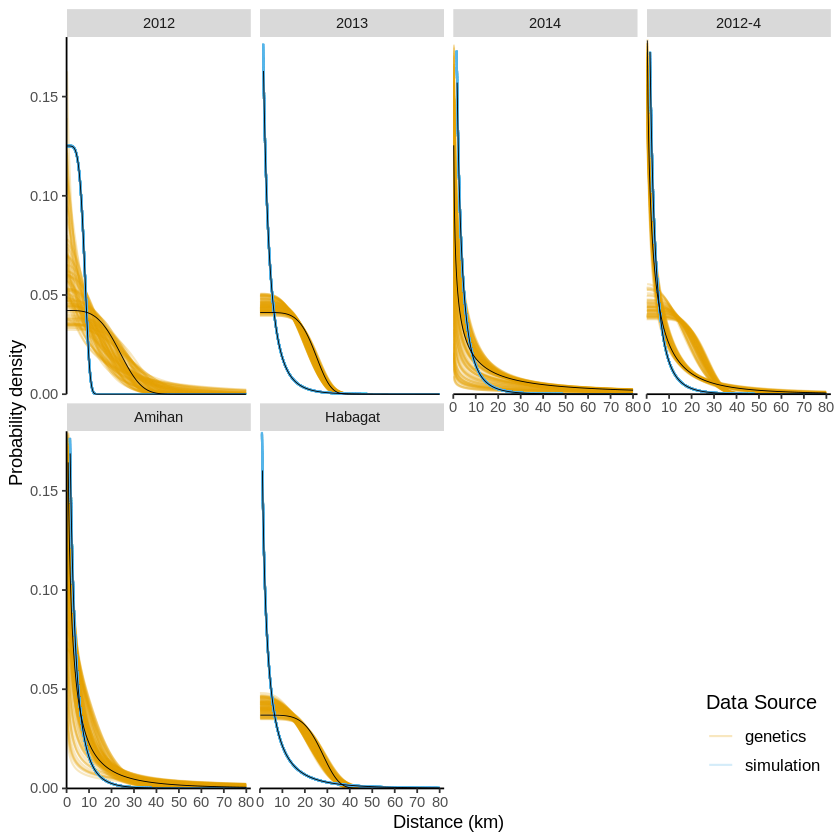

In [35]:
ToPlot$time_id <- factor(ToPlot$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
BestFits$time_id <- factor(BestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
#PubBestFits$time_id <- factor(PubBestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))

#fix the levels for data source so colors are consistent between graphs
ToPlot$data_source <- factor(ToPlot$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
BestFits$data_source <- factor(BestFits$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

kernels <- ggplot() + 
    geom_line(data= ToPlot[data_source != "simulation_15PLD"], aes(x=dist_eval, y=pdf, color=data_source, group=group), size=.6, alpha=0.25)+
    geom_line(data=BestFits[data_source != "simulation_15PLD"], aes(x=dist_eval, y=pdf, group=group), color="black", size=0.25) +
    #geom_line(data=BestFits, aes(x=dist_eval, y=pdf, color=data_source, group=group), size=0.3) + #for pub kernels plot
    #geom_line(data=PubBestFits, aes(x=dist_eval, y=pdf, group=group), color="black", size=0.3) +  #for pub kernels plot
      #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2014", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    #geom_vline(data=KernelFittingSummary[data_source != "simulation_15PLD"], aes(xintercept = mdd, color = data_source), linetype="dashed", size=0.6) + 
    #geom_vline(data=KernelFittingSummary[data_source=="simulation"], aes(xintercept = mdd), linetype="dashed", color = "#5ab4ac", size=0.6) +
    #geom_vline(data=PubKernels, aes(xintercept = mdd), linetype="dashed", color = "black", size=0.6) +  #for pub kernels plot
    theme(#legend.position = "bottom",
    legend.key=element_blank(),legend.position = c(1, 0),
    legend.justification = c(1,0),legend.title = element_text(colour="black", size = 12), legend.text = element_text(colour="black", size = 10),
    #axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
   # plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,82), expand = c(0, 0), breaks=c(seq(0, 80, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) + 
    #scale_colour_manual(name = "data_source",values = c("#CC6677","#5ab4ac"))+
    scale_colour_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
    scale_fill_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
    facet_wrap(~ time_id, ncol = 4) 
kernels
#Facet <- test + facet_grid(.~time_id) +
#  theme(aspect.ratio = 1) #+ ggtitle("2014 Simulations, red line genetics")
#Facet

#Sggsave(filename="GenPlusSimKernels.pdf", plot= kernels, path="~/oceanography/script_output/plots/", units="in", width=8, height=6)


In [3]:
head(BootKernels)

data_source,time_scale,time_id,k,theta,mdd,med,dist90,log_like,iteration
simulation,annual,2012,-2.1591255,4.8779459,4.189607,3.9869,7.8550,-149480.79,1
simulation,annual,2013,-0.4640562,0.6308995,4.195944,2.3144,10.3461,-549111.54,1
simulation,annual,2014,0.2733214,0.5289110,3.643688,1.7848,9.1493,-529918.45,1
simulation,total_years,2012-4,-0.1132395,0.5779557,3.896232,2.0312,9.7025,-1685914.22,1
simulation,monsoonal,NEM,-0.2322821,0.6088422,3.707263,1.9997,9.1795,-1571040.98,1
simulation,monsoonal,SWM,0.5635802,0.4198931,7.839023,3.1741,19.9026,-90365.48,1


In [37]:
head(GenPlusSimKernelsSamp)

time_id,data_source,k_eval,theta_eval,log_like,cutoff,best_k,best_theta,mdd,med
2012,genetics,-3.356884,3.2295042,18.04941,20.26073,-3.27091,3.52876,14.35,13.10
2012,genetics,-1.531123,1.4771674,51.43169,20.26073,-3.27091,3.52876,3.08,2.43
2012,genetics,-3.035357,4.6277419,23.35309,20.26073,-3.27091,3.52876,10.08,9.56
2012,genetics,-3.277564,0.7326512,21.04214,20.26073,-3.27091,3.52876,47.14,28.33
2012,genetics,-3.460282,2.2670809,19.82607,20.26073,-3.27091,3.52876,17.17,14.86
2012,genetics,-1.491464,2.4123523,79.36200,20.26073,-3.27091,3.52876,2.35,2.06


Saving 6.67 x 6.67 in image


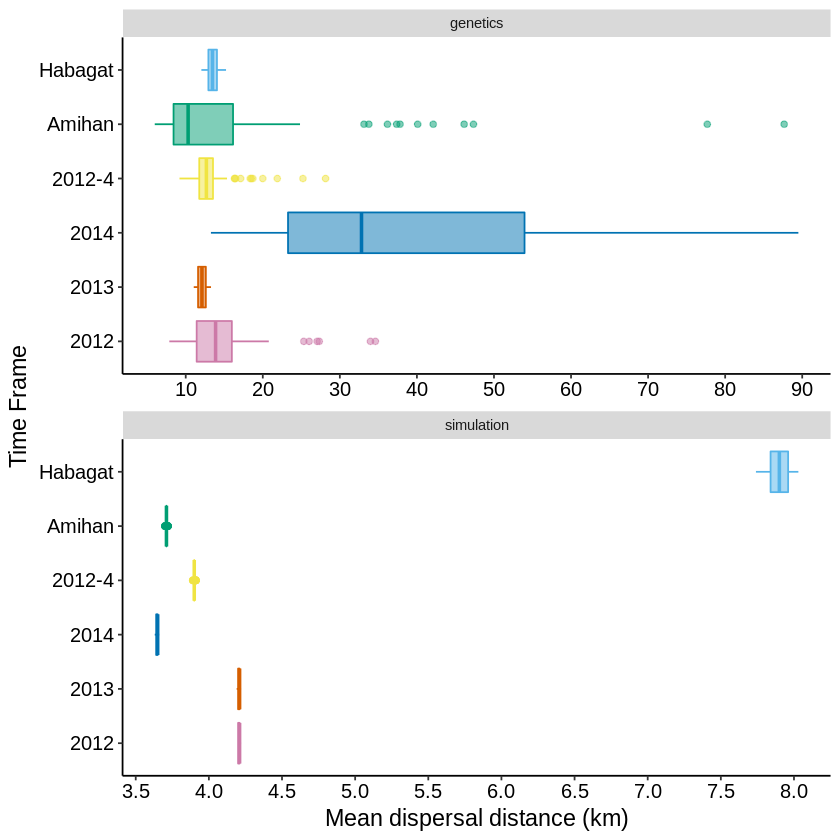

In [48]:
#panel plot of the metrics of interest
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)
GenPlusSimKernelsSamp95CI$time_id <- factor(GenPlusSimKernelsSamp95CI$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
GenPlusSimKernelsSamp95CI[data_source=="simulation_08PLD", data_source:="simulation"]
mdd_box <- ggplot() +
    geom_boxplot(data=GenPlusSimKernelsSamp95CI[mdd >0& mdd <100], aes(x=time_id, y=mdd, color=time_id, fill=time_id), alpha=0.5) +
    #geom_point(data=KernelFittingSummary, aes(x=time_id, y=mdd), fill="black",color="darkgray", shape=21) +
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    #scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Time Frame") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=12, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black"),
    axis.title.y =  element_text(size=14, color="black"), 
    axis.title.x =  element_text(size=14, color="black"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)+
    scale_y_continuous(n.breaks = 10) +
    facet_wrap(~ data_source, ncol = 1, scales = "free") 
    
mdd_box
#ggsave(filename="GenPlusSimMDD.pdf", plot= mdd_box, path="~/oceanography/script_output/plots/" )

In [46]:
GenKernels

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-3.27091,3.52876,13.02,12.02,25.08,-17.26499,genetics
annual,2013,-3.27484,5.00000,12.77,12.18,23.91,-112.75593,genetics
annual,2014,1.97231,0.26016,76.00,17.47,182.37,-78.48620,genetics
interannual,2012-4,-0.22643,0.43900,13.69,5.77,34.74,-218.61429,genetics
season,Amihan,0.76361,0.37294,12.87,4.64,32.61,-27.26112,genetics
season,Habagat,-3.38408,5.00000,14.25,13.59,26.67,-71.81265,genetics


In [66]:
#read in the bootstrapped biophysical likelihood results to plot distributions of loglike
BootKernels <- fread("~/oceanography/script_output/KernelFits/BootstrappedBiophysicalKernels08DayPLD.csv")
#BootKernelsSubSamp <- fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels08DayPLDSubSampleSim.csv")
#BootGenKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/Bootstrapped")

#head(BootLike)
BootKernels[1:100]


data_source,time_scale,time_id,k,theta,num_matches,mdd,med,dist90,log_like,iteration
simulation,annual,2012,-1.7548567,1.2823325,165487,4.331385,3.2745,9.5700,-1.259494e+06,1
simulation,annual,2013,-1.8695528,1.3600242,144844,4.611546,3.5484,10.0908,-1.224612e+06,1
simulation,annual,2014,-1.6742988,1.2183916,152531,4.200274,3.1244,9.3593,-1.102291e+06,1
simulation,total_years,2012-4,-3.0000000,1.0000000,462862,20.085537,13.9222,46.2487,1.600000e+13,1
simulation,monsoonal,NEM,-1.7208725,1.2502071,440548,4.289027,3.2169,9.5162,-3.052947e+06,1
simulation,monsoonal,SWM,-1.9841674,1.4699286,22314,4.866251,3.8271,10.5147,-5.328463e+05,1
simulation_subsample,annual,2012,-1.1670764,0.9102955,3,3.712464,2.4757,8.6803,-1.023137e+02,1
simulation_subsample,annual,2013,-2.3710601,5.0000000,18,5.174145,4.9332,9.6845,-4.757135e+02,1
simulation_subsample,annual,2014,-2.3174165,5.0000000,11,4.903899,4.6755,9.1786,-4.673266e+02,1
simulation_subsample,total_years,2012-4,-2.3503056,3.7602732,32,5.153910,4.7890,9.8657,-1.176034e+03,1


In [35]:
cor.test(BootKernels[data_source=="simulation" & time_scale=="annual", med], BootKernels[data_source=="genetics" & time_scale=="annual", med], method="spearman")
cor.test(BootKernels[data_source=="simulation_subsample" & time_scale=="annual", med], BootKernels[data_source=="genetics" & time_scale=="annual", med], method="spearman")


Warning message in cor.test.default(BootKernels[data_source == "simulation" & time_scale == :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  BootKernels[data_source == "simulation" & time_scale == "annual",  and BootKernels[data_source == "genetics" & time_scale == "annual",     med] and     med]
S = 6799837020, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5110751 


Warning message in cor.test.default(BootKernels[data_source == "simulation_subsample" & :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  BootKernels[data_source == "simulation_subsample" & time_scale ==  and BootKernels[data_source == "genetics" & time_scale == "annual",     "annual", med] and     med]
S = 5680271866, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2622828 


ERROR: Error in plot(BootKernelsSubSamp[data_source == "simulation" & time_scale == : object 'BootKernelsSubSamp' not found


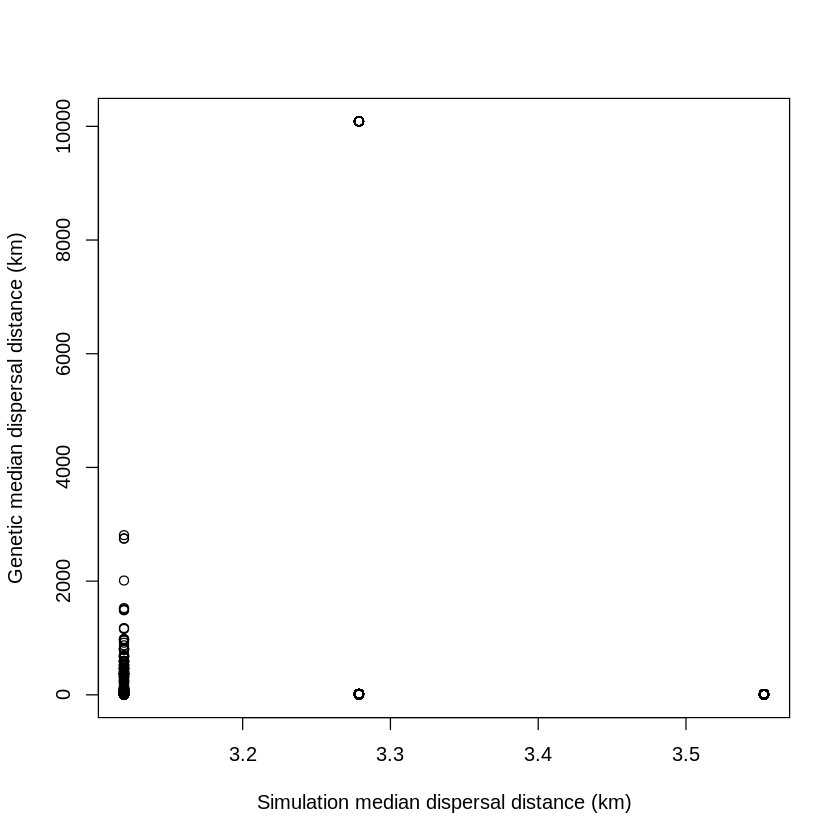

In [36]:
#pdf(file = "~/oceanography/script_output/plots/MedCorrelation.pdf")
MDDCor <- plot(BootKernels[data_source=="simulation" & time_scale=="annual", med], BootKernels[data_source=="genetics" & time_scale=="annual", med], xlab="Simulation median dispersal distance (km)", ylab="Genetic median dispersal distance (km)")
#dev.off()
#plot(BootKernelsSubSamp[data_source=="simulation" & time_scale=="annual", med], BootKernelsSubSamp[data_source=="genetics" & time_scale=="annual", med], xlab="Simulation median dispersal distance (km)", ylab="Genetic median dispersal distance (km)")

In [38]:
#plot the variation (CV) to see if the scale of variation matches genetics and simulations
KernelFitsForCV <- rbind(GenKernels, SimKernels) #the number of decimal places in bootstrapped and best fit data should be consistent, use this table because there's no rounding
MLEVariation <-KernelFitsForCV[time_scale != "interannual",.( cv_theta=round(cv(theta),3), cv_mdd=round(cv(mdd),3)), by=c("data_source", "time_scale")]   
MLEVariation

#fwrite(MLEVariation, "~/oceanography/script_output/KernelFits/VariationSummary.csv")

data_source,time_scale,cv_theta,cv_mdd
genetics,annual,0.828,1.074
genetics,season,1.218,0.072
simulation_08PLD,annual,0.093,0.076
simulation_08PLD,season,0.238,0.388


In [75]:
nrow(BootKernels)
nrow(BootKernels[num_matches ==0])

[1] 18000

[1] 473

In [72]:
#get a distribution of CV for bootstrapped biophysical kernels

#BootBioPhys <-fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels08DayPLD.csv")[, data_source := "simulation_08PLD"][#fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels15DayPLD.csv")[, data_source := "simulation_15PLD"])
#    , prop1 :=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 1, method = "pcubature")$integral*2, 3),by=c("time_scale","data_source","k", "theta", "iteration")][
#     , prop30 :=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 30, method = "pcubature")$integral*2, 3),by=c("time_scale","data_source", "k", "theta","iteration")][
#    , dist99 :=round(nleqslv(x = 7, fn = cdf_solve99, k=k, theta=theta)$x, 2),by=c("time_scale","data_source","k", "theta", "iteration")]
#
#read in the bootstrapped kernels to compare distribution of CV 

   

BootBioPhysCV <- BootKernels[time_scale != "total_years" & num_matches>0 ,.( cv_theta=round(cv(theta),3), cv_mdd=round(cv(mdd),3)), by=c("time_scale","data_source", "iteration")] #, sd_kurtosis=round(sd(kurtosis), 2) 

In [93]:
#ToPlotVariation <- melt(MLEVariation, id.vars=c("data_source","time_scale"))
ToPlotBoot <- melt(BootBioPhysCV, id.vars=c("iteration","time_scale", "data_source"))

#head(ToPlotVariation)
head(ToPlotBoot)


iteration,time_scale,data_source,variable,value
1,annual,simulation,cv_theta,0.055
1,monsoonal,simulation,cv_theta,0.114
1,annual,simulation_subsample,cv_theta,0.649
1,monsoonal,simulation_subsample,cv_theta,0.229
1,annual,genetics,cv_theta,1.245
1,monsoonal,genetics,cv_theta,0.403


In [11]:
#test <- rbind(ToPlotBoot[, stat := "boot"], ToPlotVariation[,stat := "MLE"], fill=TRUE)
#tail(test)

Saving 6.67 x 6.67 in image


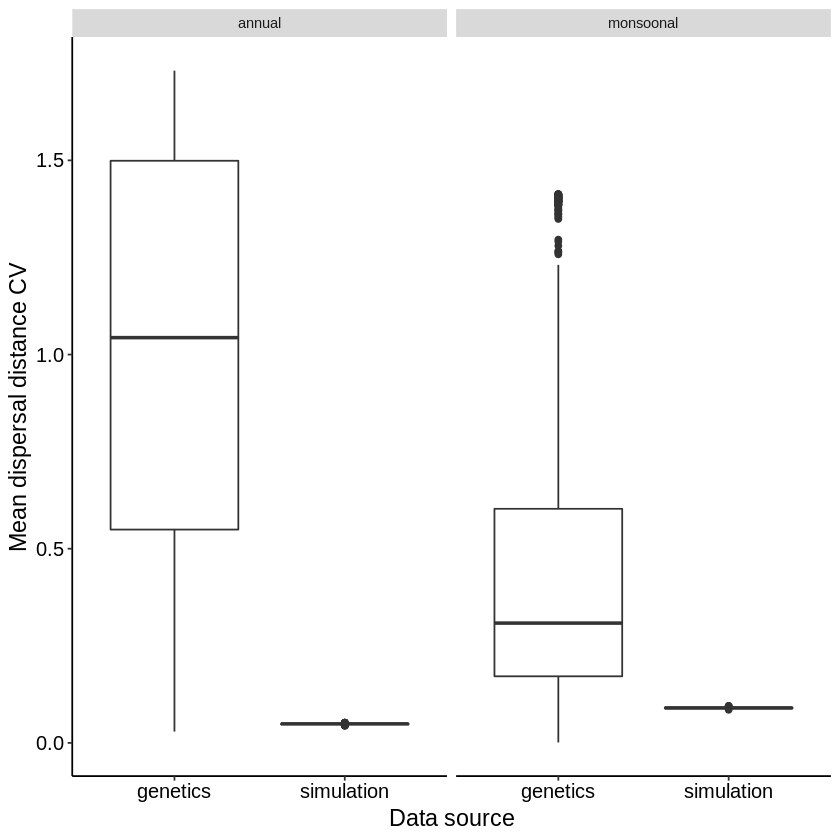

In [95]:
#ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"
#ToPlotBoot$data_source <- factor(ToPlotBoot$data_source, levels=c("genetics", "subsampled simulation", "simulation"))#, "simulation_15PLD"
#test$data_source <- factor(test$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

CVPlotAnnual <- ggplot(data=ToPlotBoot[variable=="cv_mdd" & data_source!="simulation_subsample" & value >0], aes(x=data_source , y=value)) +
    geom_boxplot(data=ToPlotBoot[variable=="cv_mdd" & data_source!="simulation_subsample" & value >0]) +#aes(x=data_source, y=value, color=time_scale)#, binwidth = 0.005
    #geom_histogram(data=ToPlotBoot[variable !="sd_k" & time_scale=="annual"& data_source=="simulation_15PLD"], aes(x=value), color="#CC79A7", fill="#CC79A7", binwidth = 0.005) +
    #geom_point(data=test[stat== "MLE" & data_source =="genetics" &variable=="cv_mdd"]) + #, aes(x=data_source, y=value,  color=time_scale)
    ylab("Mean dispersal distance CV") +
    xlab("Data source")+
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=12, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black"),
    axis.title.x =  element_text(size=14, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black"))+
    scale_x_discrete(labels=c("genetics", "simulation"))+ # "subsampled\nsimulation",
    #scale_colour_manual(values=cbbPalette)+
    #scale_fill_manual(values=cbbPalette)+
    facet_wrap(~  time_scale, ncol = 2) 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlotAnnual

#ggsave(filename="BootstrappedCVComparisonBothTimeScalesMDD.pdf", plot= CVPlotAnnual, path="~/oceanography/script_output/plots/" )


In [76]:
#likelihood plot
BootLike <- fread(file="~/oceanography/script_output/KernelFits/BootstrappedBiophysicalLikelihoods08DayPLD.csv")[
    ,time_scale := ifelse(time_scale %like% "monsoon", "monsoonal", "annual")]

head(BootLike)

comparison,time_scale,data_source,log_like,iteration
gen_total_bio_total,annual,simulation,-56924.780,1
gen_annual_bio_annual,annual,simulation,-45206.908,1
gen_monsoonal_bio_monsoonal,monsoonal,simulation,-14890.595,1
gen_monsoonal_bio_total,monsoonal,simulation,-36210.048,1
gen_total_bio_total,annual,simulation_subsample,-8521.242,1
gen_annual_bio_annual,annual,simulation_subsample,-4999.046,1


In [12]:
#how often is each comparison a better fit? WRONG figure out another time
#sum(isTRUE(BootLike[comparison=="gen_monsoonal_bio_total", .(log_like)]<BootLike[comparison=="gen_monsoonal_bio_monsoonal", .(log_like)]))
#test <- BootLike[comparison=="gen_total_bio_total", .(log_like)]<BootLike[comparison=="gen_annual_bio_annual", .(log_like)]


In [63]:
tail(BootLike[data_source=="simulation_subsample"])

comparison,time_scale,data_source,log_like,iteration
gen_monsoonal_bio_monsoonal,monsoonal,simulation_subsample,-96.14105,999
gen_monsoonal_bio_total,monsoonal,simulation_subsample,-946.65120,999
gen_total_bio_total,annual,simulation_subsample,-1381.44127,1000
gen_annual_bio_annual,annual,simulation_subsample,-528.59886,1000
gen_monsoonal_bio_monsoonal,monsoonal,simulation_subsample,-119.47525,1000
gen_monsoonal_bio_total,monsoonal,simulation_subsample,-859.57669,1000


Saving 6.67 x 6.67 in image


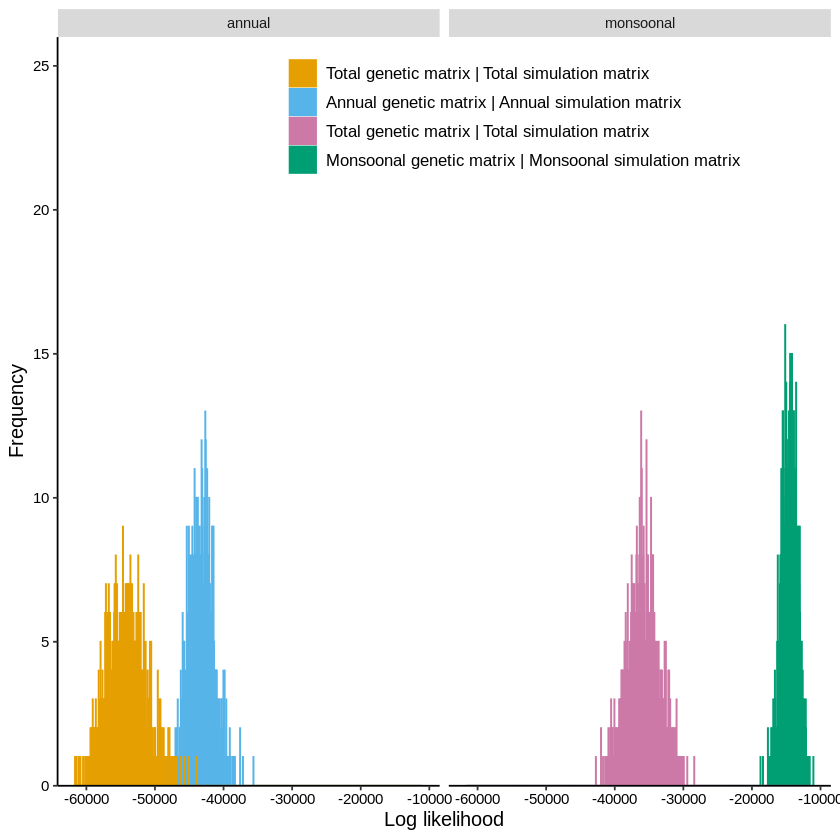

In [87]:
cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7", "#009E73")#"#F0E442", "#0072B2", "#D55E00", "#CC79A7")
#BootLike$comparison <- factor(BootLike$comparison, levels=c("gen_annual_bio_annual", "gen_total_bio_total", "mc"), labels=c("MBB", "MAA", "MCC"))


likelihood_hist <- ggplot() +
    geom_histogram(data=BootLike[data_source=="simulation"], aes(x=log_like, fill=comparison, color = comparison), binwidth = 30) +
    ylab("Frequency") +
    xlab("Log likelihood")+
    scale_y_continuous(expand = c(0,0), limits = c(0,26)) + 
    #scale_x_continuous(expand = c(0,0), limits = c(0,26)) + 
    theme(legend.title = element_blank(),
    legend.key=element_blank(),
    legend.position = c(0.6, 0.9), 
    legend.text = element_text(colour="black", size = 10),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),
    axis.title.y =  element_text(size=12, color="black"),
    axis.title.x =  element_text(size=12, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=9, color="black"), 
    axis.text.x =  element_text(size=9, color="black"))+
    scale_colour_manual(values=cbbPalette, breaks=c("gen_total_bio_total","gen_annual_bio_annual","gen_monsoonal_bio_total", "gen_monsoonal_bio_monsoonal"),
                      labels=c("Total genetic matrix | Total simulation matrix", "Annual genetic matrix | Annual simulation matrix", "Total genetic matrix | Total simulation matrix", "Monsoonal genetic matrix | Monsoonal simulation matrix"))+
    scale_fill_manual(values=cbbPalette, breaks=c("gen_total_bio_total","gen_annual_bio_annual","gen_monsoonal_bio_total", "gen_monsoonal_bio_monsoonal"),
                      labels=c("Total genetic matrix | Total simulation matrix", "Annual genetic matrix | Annual simulation matrix", "Total genetic matrix | Total simulation matrix", "Monsoonal genetic matrix | Monsoonal simulation matrix"))+
facet_wrap( ~ time_scale) 
likelihood_hist

ggsave(filename="BootstrappedLikelihoodComparisonBothTimeScalesHistogram.pdf", plot= likelihood_hist, path="~/oceanography/script_output/plots/")


In [28]:
BootLike[time_scale=="years" &log_like > -10000]

comparison,time_scale,log_like,iteration


In [152]:
lower_peak <- unique(BootLike[comparison=="gen_annual_bio_annual" & log_like < -30000, iteration])

In [157]:
summary(BootKernels[time_scale != "monsoonal" &iteration %in% lower_peak])
summary(BootKernels[time_scale != "monsoonal" &iteration %!in% lower_peak])

 data_source         time_scale          time_id                k           
 Length:5960        Length:5960        Length:5960        Min.   :-10.0000  
 Class :character   Class :character   Class :character   1st Qu.: -3.0000  
 Mode  :character   Mode  :character   Mode  :character   Median : -0.4718  
                                                          Mean   : -0.8093  
                                                          3rd Qu.:  0.2838  
                                                          Max.   :  8.1415  
     theta             mdd                 med                dist90        
 Min.   :0.1500   Min.   :    3.629   Min.   :    1.766   Min.   :    7.80  
 1st Qu.:0.4772   1st Qu.:    4.205   1st Qu.:    2.545   1st Qu.:   10.03  
 Median :0.6293   Median :   11.088   Median :    5.014   Median :   23.54  
 Mean   :1.6939   Mean   :  131.783   Mean   :   61.040   Mean   :  251.68  
 3rd Qu.:3.2514   3rd Qu.:   20.086   3rd Qu.:   12.271   3rd Qu.:   46.25  

 data_source         time_scale          time_id                k           
 Length:2040        Length:2040        Length:2040        Min.   :-10.0000  
 Class :character   Class :character   Class :character   1st Qu.: -3.0000  
 Mode  :character   Mode  :character   Mode  :character   Median : -0.4720  
                                                          Mean   : -0.7891  
                                                          3rd Qu.:  0.2828  
                                                          Max.   :  8.0427  
     theta             mdd                 med                dist90        
 Min.   :0.1500   Min.   :    3.630   Min.   :    1.768   Min.   :    7.82  
 1st Qu.:0.4840   1st Qu.:    4.204   1st Qu.:    2.585   1st Qu.:   10.05  
 Median :0.6293   Median :   10.901   Median :    4.929   Median :   23.53  
 Mean   :1.6973   Mean   :  140.554   Mean   :   57.498   Mean   :  265.83  
 3rd Qu.:3.3000   3rd Qu.:   20.086   3rd Qu.:   12.258   3rd Qu.:   46.25  

Saving 6.67 x 6.67 in image


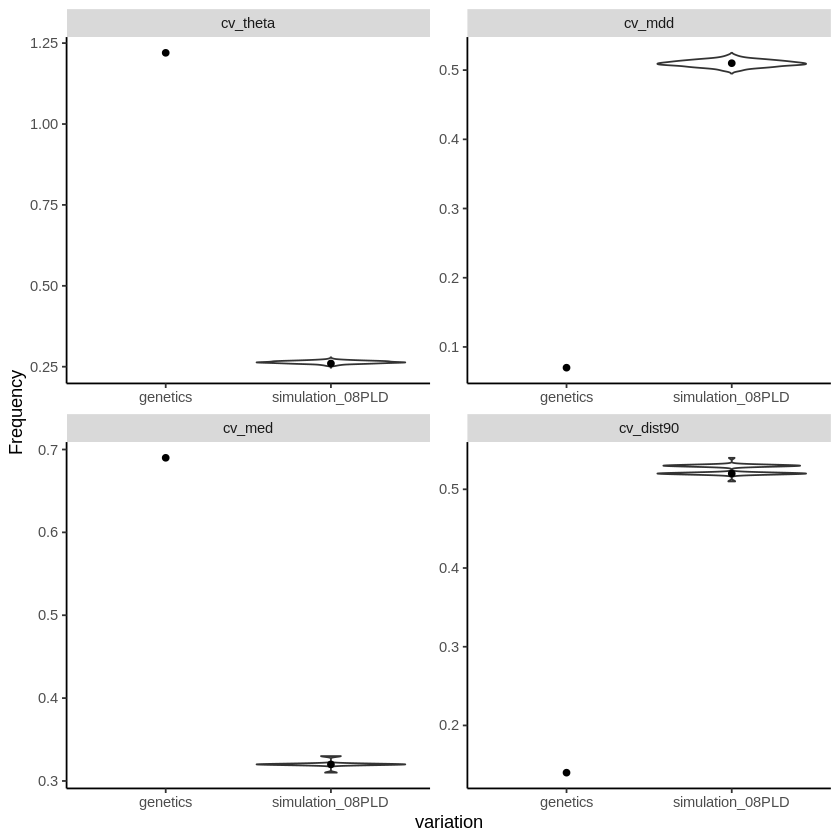

In [124]:
ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

CVPlotMonsoon <- ggplot() +
    geom_violin(data=ToPlotBoot[variable !="sd_k" & time_scale=="season"& data_source != "simulation_15PLD"], aes(x=data_source, y=value)) +#, binwidth = 0.005
    #geom_histogram(data=ToPlotBoot[variable !="sd_k" & time_scale=="annual"& data_source=="simulation_15PLD"], aes(x=value), color="#CC79A7", fill="#CC79A7", binwidth = 0.005) +
    geom_point(data=ToPlotVariation[variable !="sd_k"& variable != "sd_kurtosis" &time_scale=="season"& data_source != "simulation_15PLD"], aes(x=data_source, y=value)) +
    ylab("Frequency") +
    xlab("variation")+
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"))+
    scale_colour_manual(values=cbbPalette)+
    scale_fill_manual(values=cbbPalette)+
    facet_wrap(~  variable, ncol = 2, scales = "free") 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlotMonsoon

#ggsave(filename="BootstrappedCVComparisonMonsoon.png", plot= CVPlotMonsoon, path="~/oceanography/script_output/plots/" )

In [105]:
#relationship with enso?
#annual&monsoon fits and 2011 as well
#define monsoon months
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)
#load data
AnnualMonsoonKernels <- fread(file="~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFitsAnnualMonsoon08DayPLD.csv")
enso <- fread(file="~/oceanography/empirical_data/environment/enso/meiv2.csv")
#setnames(enso, "YEAR", "year")
setnames(enso, c("YEAR","DJ", "JF", "FM", "MA", "AM", "MJ", "JJ", "JA", "AS", "SO", "ON", "ND"), c("year","12,1", "1,2", "2,3", "3,4", "4,5", "5,6", "6,7", "7,8", "8,9", "9,10", "10,11", "11,12"))
#reshape to join
ENSO <- melt(enso, id.vars="year", variable.name = "month_window", value="mei_index")[, `:=`(year=as.numeric(year), month_window=as.character(month_window))][
    year %in% c(2010,2011, 2012, 2013, 2014)][
    , paste0("month", 1:2) := tstrsplit(month_window, ",")]#split the month window column so each month/year combo has a row 

ENSOMonthly <- unique(melt(ENSO[,-"month_window"], id.vars=c("year", "mei_index"), value.name="month")[,-"variable"][#reshape so each month/year combo has a row
    , month := as.numeric(month)][ # to match list of monsoon months
    , monsoon := ifelse(month %in% NEM, "NEM", "SWM")][ #use unique because each month has 2 measurements of mei because it's measured in two month windows. just take the first value so it's consistent
    , year_sampled := ifelse(month %in% SWM, year+1, ifelse(month %in% c(11,12), year+1, year))][ #to match the way we divided years, if there is a SWM fit, it's the data from the year preceding it's "year_sampled" based on our field season timing. If it's the NEM months, then it is a part of the NEM  year that season ends, so a NEM month in 2012 could be any month before June in 2012 but also any month after October in 2011 
    , time_id := paste0(monsoon, year_sampled)][#make a time_id column to join with annual monsoon summary table
    , month_avg_mei_index := mean(mei_index), by=c("month", "year")][
    , annual_monsoon_avg_mei := mean(month_avg_mei_index), by=c("time_id")], by="time_id")

#join kernels and ENSO data together
AnnualMonsoonENSO <- left_join(AnnualMonsoonKernels, ENSOMonthly, by="time_id")

In [106]:
AnnualMonsoonENSO 

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,year,mei_index,month,monsoon,year_sampled,month_avg_mei_index,annual_monsoon_avg_mei
annual_monsoon,NEM2011,-1.75309,1.30265,4.262,3.24,9.39,-1045881.8,simulation_08PLD,2010,0.93,12,NEM,2011,-0.490,-1.417500
annual_monsoon,NEM2012,-1.73326,1.26304,4.300,3.24,9.52,-1120211.9,simulation_08PLD,2011,-1.83,12,NEM,2012,-1.535,-0.683750
annual_monsoon,NEM2013,-1.85889,1.35246,4.584,3.52,10.04,-1028977.7,simulation_08PLD,2012,-1.08,12,NEM,2013,-0.575,-0.445625
annual_monsoon,NEM2014,-1.50649,1.11461,3.917,2.83,8.86,-901086.4,simulation_08PLD,2013,-0.05,12,NEM,2014,-0.200,-0.177500
annual_monsoon,SWM2011,-2.14126,1.60872,5.359,4.31,11.41,-371065.6,simulation_08PLD,2010,-2.40,7,SWM,2011,-2.415,-2.273750
annual_monsoon,SWM2012,-1.92231,1.47343,4.566,3.59,9.86,-141712.1,simulation_08PLD,2011,-0.88,7,SWM,2012,-0.870,-1.111250
annual_monsoon,SWM2013,-1.92912,1.40630,4.763,3.70,10.37,-195363.6,simulation_08PLD,2012,-0.06,7,SWM,2013,0.120,-0.121250
annual_monsoon,SWM2014,-2.08679,1.56256,5.170,4.13,11.06,-197547.8,simulation_08PLD,2013,-0.50,7,SWM,2014,-0.675,-0.388750



Call:
lm(formula = mdd ~ annual_monsoon_avg_mei + monsoon, data = AnnualMonsoonENSO)

Residuals:
       1        2        3        4        5        6        7        8 
-0.12705  0.03381  0.35767 -0.26443  0.17684 -0.42152 -0.05877  0.30345 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              4.1517     0.1982  20.952 4.59e-06 ***
annual_monsoon_avg_mei  -0.1674     0.1692  -0.989   0.3679    
monsoonSWM               0.6498     0.2333   2.785   0.0387 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 5 degrees of freedom
Multiple R-squared:  0.6748,	Adjusted R-squared:  0.5447 
F-statistic: 5.188 on 2 and 5 DF,  p-value: 0.06031


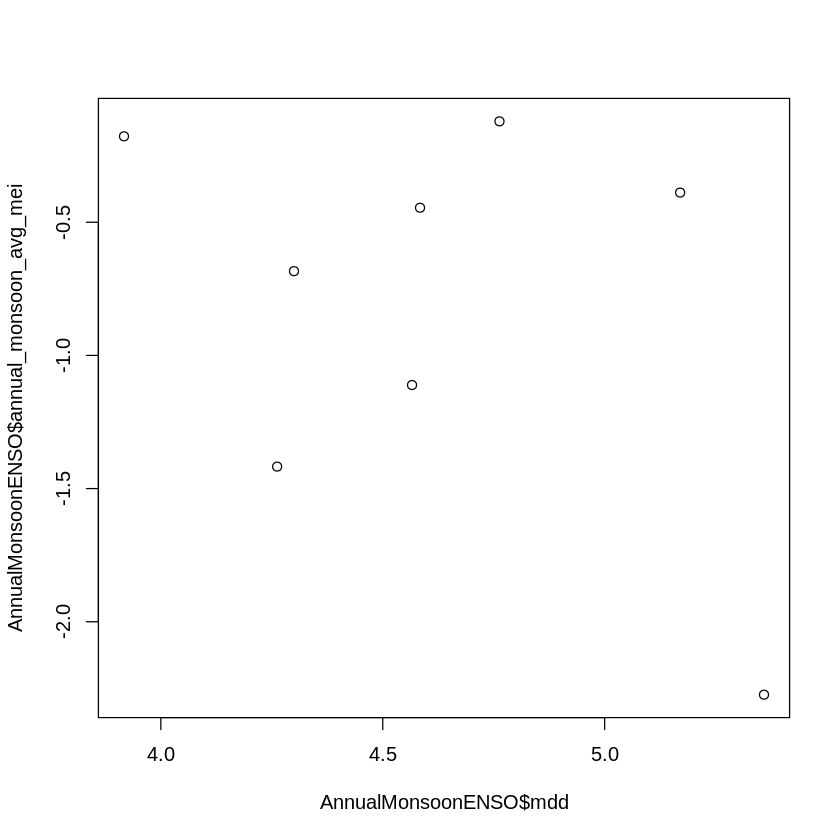

In [107]:

plot(AnnualMonsoonENSO$mdd, AnnualMonsoonENSO$annual_monsoon_avg_mei)
test_mod <- lm(data=AnnualMonsoonENSO, mdd ~ annual_monsoon_avg_mei+ monsoon)
summary(test_mod)

Saving 6.67 x 6.67 in image


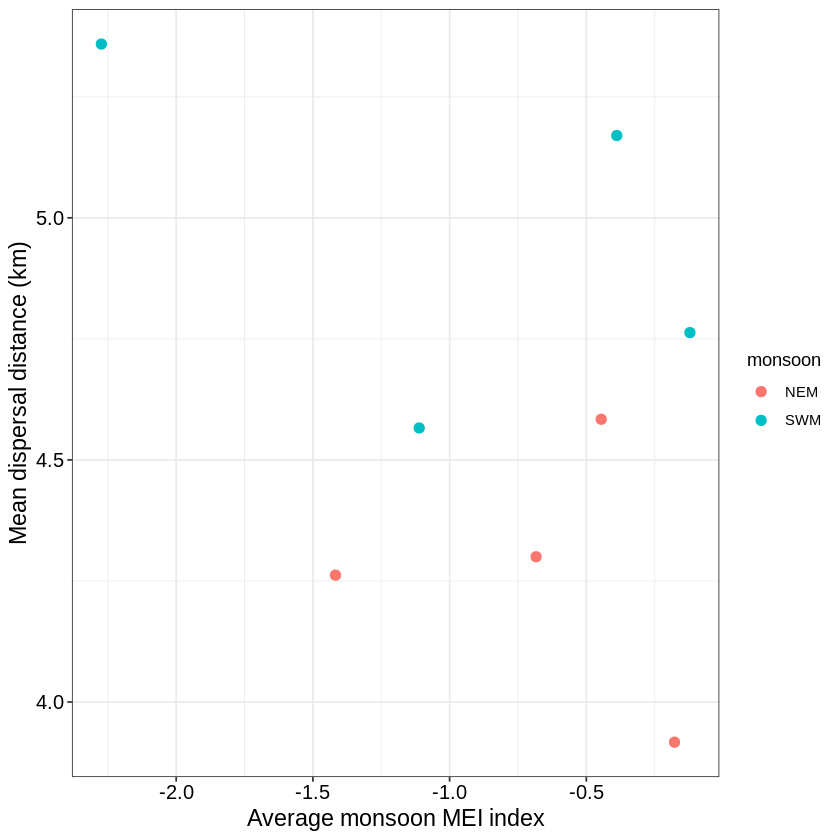

In [116]:
MonsoonKernelsENSO <- ggplot() +
    geom_point(data=AnnualMonsoonENSO, aes(x=annual_monsoon_avg_mei, y=mdd, color=monsoon), size=2.5) +
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
    ylab("Mean dispersal distance (km)")+
    xlab("Average monsoon MEI index")
MonsoonKernelsENSO
#ggsave(filename="MonsoonKernelsENSO.png",  plot=MonsoonKernelsENSO, path="~/oceanography/script_output/plots/", units="in")


In [119]:
ENSOMonthly

year,mei_index,month,monsoon,year_sampled,time_id,month_avg_mei_index,annual_monsoon_avg_mei
2010,0.93,12,NEM,2011,NEM2011,-0.490,-1.4175000
2011,-1.83,12,NEM,2012,NEM2012,-1.535,-0.6837500
2012,-1.08,12,NEM,2013,NEM2013,-0.575,-0.4456250
2013,-0.05,12,NEM,2014,NEM2014,-0.200,-0.1775000
2014,-0.51,12,NEM,2015,NEM2015,-0.085,0.1275000
2010,1.28,1,NEM,2010,NEM2010,1.105,0.1383333
2010,-2.40,7,SWM,2011,SWM2011,-2.415,-2.2737500
2011,-0.88,7,SWM,2012,SWM2012,-0.870,-1.1112500
2012,-0.06,7,SWM,2013,SWM2013,0.120,-0.1212500
2013,-0.50,7,SWM,2014,SWM2014,-0.675,-0.3887500


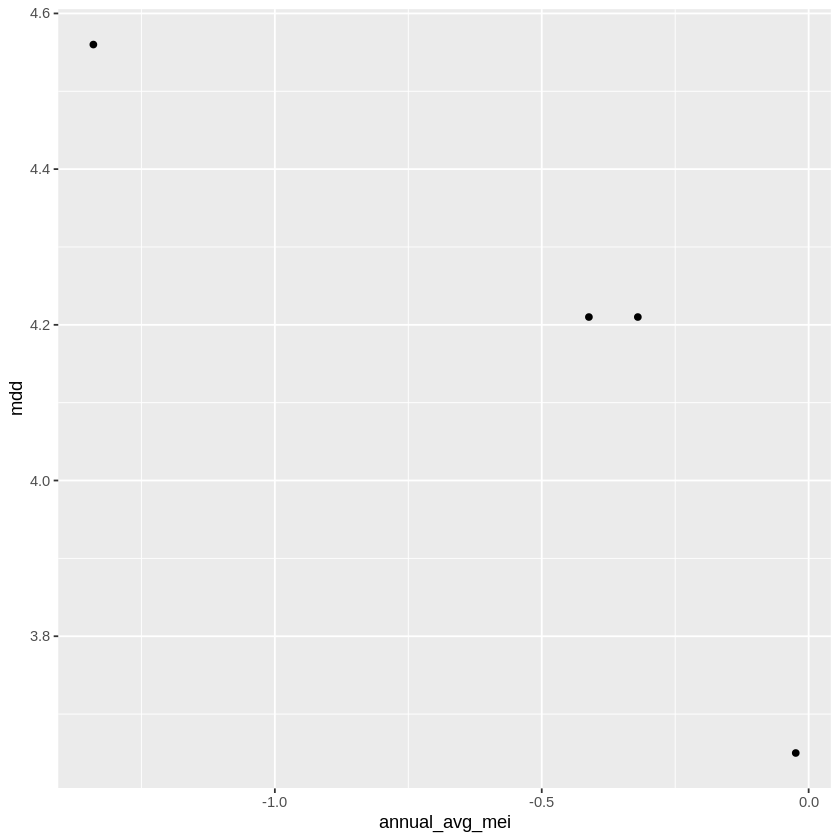

In [185]:
ggplot() +
    geom_point(data=AnnualKernelsENSO[data_source=="simulation"], aes(x=annual_avg_mei, y=mdd))